# Simple Monitor in 72 bytes (ARM64)

Last edited: 2025-06-15

Based on some ideas from: <https://hackaday.com/2025/05/27/a-forth-os-in-46-bytes/>

Environment 1: Termux, SSH server, proot-distro Ubuntu 22.04 AArch64, GNU tools and JupyterLab server, where the code is developed.

Environment 2: qemu running on a PC AMD64 host machine, where the final code is tested in a ARM64 virtual machine.

Before proceeding, just out of curiosity, it's worth noting the significant differences in the boot process for modern AArch64 devices (ARMv8-A and later) compared to [x86 BIOS/MBR systems](https://wiki.osdev.org/BIOS). The concept of a '512-byte boot sector' isn't standard or common in the contemporary ARM ecosystem.

For example, on the Raspberry Pi (AArch64 models without SPI flash, like the Pi 3 and early Pi 4 variants), the immutable [Boot ROM](https://www.raspberrypi.com/documentation/computers/raspberry-pi.html#raspberry-pi-boot-flow) loads the proprietary bootcode.bin file (20–50 KB) directly from the SD card. This is executed by the GPU (VideoCore), which then loads start.elf (3–6 MB) and fixup.dat. Only after this GPU-driven initialization and DRAM setup does the AArch64 CPU take over, typically loading [U-Boot](https://docs.u-boot.org/en/latest/) (500 KB–1.5 MB) or the Linux kernel.

On [Allwinner](https://linux-sunxi.org/BROM) and [Rockchip](https://opensource.rock-chips.com/wiki_Boot_option) AArch64 SoCs, the Boot ROM (BROM, typically a few KB) loads an SPL/miniloader (tens to hundreds of KB) into SRAM (64–128 KB). This SPL initializes DRAM, then executes [Trusted Firmware-A (TF-A)](https://trustedfirmware-a.readthedocs.io/), followed by U-Boot (hundreds of KB to several MB), which loads the [Device Tree Blob (DTB)](https://www.devicetree.org/) and the Linux kernel. Unlike the Raspberry Pi, these platforms use the ARM CPU for the entire boot sequence, with GPU initialization occurring later.

On Apple Silicon Macs, the boot process is a secure multi-stage chain. It begins with the immutable [Secure ROM](https://support.apple.com/guide/security/securing-mac-firmware-secf756d8a6f/web) (Boot ROM, a few KB) loading the Low-Level Bootloader (LLB, or iBoot1, typically 600 KB–1 MB) from internal storage into SRAM (e.g., 256–512 KB). The LLB initializes DRAM and loads iBoot2 (450–800 KB) from the preboot volume (within the APFS container) on the internal SSD. iBoot2 handles system firmware loading, [Apple Device Tree](https://www.theiphonewiki.com/wiki/Device_Tree) setup, and macOS kernel validation.

ARM-based laptops (e.g., Windows on ARM or Linux devices) typically follow a [UEFI-based boot process](https://learn.microsoft.com/en-us/windows/arm/overview) similar to modern x86 systems. The SoC's Boot ROM (a few KB) loads [TF-A](https://developer.arm.com/documentation/den0024/latest/) (hundreds of KB to a few MB) from non-volatile storage (SPI flash, eMMC, or UFS) into SRAM (usually 256–512 KB). TF-A handles CPU initialization and security, then passes control to [UEFI firmware (EDK2-based)](https://github.com/tianocore/tianocore.github.io/wiki/EDK-II), which configures hardware and loads the OS bootloader (e.g., Windows Boot Manager or [GRUB](https://www.gnu.org/software/grub/)) from a FAT32 EFI System Partition. The bootloader then launches the OS kernel.

Despite varying implementations, modern ARM boot processes share key principles that differ fundamentally from legacy x86 BIOS/MBR systems. All begin with an immutable [Boot ROM](https://developer.arm.com/documentation/102412/0102/System-control) (hardware root of trust) that loads a small initial bootloader (e.g., bootcode.bin, SPL, or TF-A) from non-volatile storage. This bootloader then initializes critical hardware (DRAM, CPU modes) and chains to larger firmware stages (U-Boot, UEFI, or Apple's iBoot) — a stark contrast to x86's single 512-byte boot sector approach.

The BROM (Boot ROM), a small, immutable program "burned" into the chip by the manufacturer, initializes basic hardware and loads the SPL/miniloader (BL1) into SRAM (typically limited to 64–256 KB, depending on the SoC). The BL1 itself is usually 15–64 KB in size (e.g., ~15 KB in [Rockchip SoCs](https://opensource.rock-chips.com/wiki_Boot_option), ~64 KB in some [Qualcomm](https://www.qualcomm.com/content/dam/qcomm-martech/dm-assets/documents/secure-boot-and-image-authentication-technology.pdf)/[MediaTek](https://mediatek.gitlab.io/aiot/doc/aiot-dev-guide/master/sw/yocto/secure-boot.html) chips) and serves as the first customizable boot stage, often implemented in open-source projects like [Arm Trusted Firmware-A](https://trustedfirmware-a.readthedocs.io/) or [U-Boot](https://docs.u-boot.org/en/latest/). Written in assembly (for low-level hardware control) and C (for higher-level logic), BL1 executes from SRAM, performs critical initialization (e.g., DRAM setup), and loads the next stage (BL2 or U-Boot) before handing off to the full bootloader or OS.

Unlike x86, AArch64 has no BIOS — the hardware [Boot ROM (BROM)](https://developer.arm.com/documentation/102412/0102/System-control) handles only the bare minimum (e.g., loading BL1 from storage) and provides no runtime services. All hardware initialization (DRAM, clocks, etc.) must be done by the bootloader. For any I/O operations like keyboard input or video output, your code must interface directly with the hardware (e.g., USB controllers or display framebuffers) — there are no prebaked BIOS interrupts like [INT 10h/16h](https://wiki.osdev.org/BIOS).

The main idea of the following work is to develop a custom BL1 booloader, which is the first changeable code in the boot process.

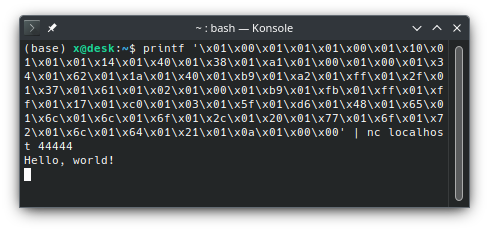

Here is the complete 72-byte source of Monitor in ARM64 opcodes:

In [1]:
! hexdump -C bootloader.img

00000000  13 20 a1 d2 14 00 a8 d2  94 02 74 b2 f5 03 14 aa  |. ........t.....|
00000010  60 1a 40 b9 e0 ff 27 37  60 02 40 b9 00 01 00 34  |`.@...'7`.@....4|
00000020  1f 04 00 71 61 ff ff 54  60 1a 40 b9 e0 ff 27 37  |...qa..T`.@...'7|
00000030  60 02 40 b9 a0 16 00 38  f6 ff ff 17 80 02 3f d6  |`.@....8......?.|
00000040  f5 03 14 aa f3 ff ff 17                           |........|
00000048


In [2]:
! size bootloader.elf

   text	   data	    bss	    dec	    hex	filename
     72	      0	      0	     72	     48	bootloader.elf


It's perhaps worth noting that this is 64-bit code for an architecture that uses 4 bytes (32 bits) per instruction, and the boot process cannot rely on an x86 BIOS or runtime services, with all hardware initialization being done by the bootloader. For any I/O operations, such as keyboard input or video output, your code must interact directly with the hardware; there are no pre-configured BIOS interrupts like INT 10h/16h.

The monitor has two instructions:

- 1 is "compile"
- 0 is "execute"

When loaded after boot, the monitor listens on the serial port for instructions. Instruction 1 must be followed by a byte of an assembly opcode to be compiled into a fixed memory location. Instruction 0 starts the compiled program.

And that's it!

On the AMD64 PC host computer running qemu ARM64, you can send commands to the monitor.

## Usage

The Notebook [bootloader.ipynb](bootloader.ipynb) contains the source code for the monitor, the assembly instructions, and also the Python code to facilitate the translation of the opcodes into a sequence of commands to be sent over the serial port. The image file that contains the machine code for the monitor is the `bootloader.img`.

Boot the machine (here qemu) :

    qemu-system-aarch64 \
        -machine virt \
        -cpu cortex-a53 \
        -nographic \
        -kernel bootloader.img \
        -serial tcp::44444,server,nowait \
        -monitor none

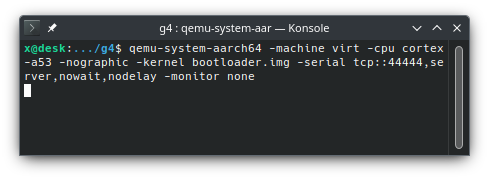

At this point, the monitor is waiting for input on the serial port. To output the hello world example on the serial port, we open a second terminal and enter:

    printf '\x01\x00\x01\x01\x01\x00\x01\x10\x01\x01\x01\x14\x01\x40\x01\x38\x01\xa1\x01\x00\x01\x00\x01\x34\x01\x62\x01\x1a\x01\x40\x01\xb9\x01\xa2\x01\xff\x01\x2f\x01\x37\x01\x61\x01\x02\x01\x00\x01\x b9\x01\xfb\x01\xff\x01\xff\x01\x17\x01\xc0\x01\x03\x01\x5f\x01\xd6\x01\x48\x01\x65\x01\x6c\x01\ 'x6c' | nc localhost 44444

Hello world source:

In [6]:
! as -a hw.s

AARCH64 GAS  hw.s 			page 1


   1              	.text
   2              	.global _start
   3              	_start:
   4 0000 00010010 	    adr x0, msg
   5              	loop:
   6 0004 01144038 	    ldrb w1, [x0], #1
   7 0008 A1000034 	    cbz w1, done
   8 000c 621A40B9 	    ldr w2, [x19, #24]
   9 0010 A2FF2F37 	    tbnz w2, #5, loop
  10 0014 610200B9 	    str w1, [x19]
  11 0018 FBFFFF17 	    b loop
  12              	done:
  13 001c C0035FD6 	    ret
  14              	msg:
  15 0020 48656C6C 	    .ascii "Hello, world!\n\0"
  15      6F2C2077 
  15      6F726C64 
  15      210A00
AARCH64 GAS  hw.s 			page 2


DEFINED SYMBOLS
                hw.s:3      .text:0000000000000000 _start
                hw.s:4      .text:0000000000000000 $x
                hw.s:14     .text:0000000000000020 msg
                hw.s:5      .text:0000000000000004 loop
                hw.s:12     .text:000000000000001c done
                hw.s:15     .text:0000000000000020 $d

NO UNDEFINED SYMBOLS
